## **Notebook #8**
## Generative Adversarial Networks for the MNIST dataset.
**Professor:** Fernando J. Von Zuben <br>
**Aluno(a):** Arthur Felipe dos Santos Fernandes


In [3]:
from __future__ import print_function, division

from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D, LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import tensorflow as tf
import matplotlib.pyplot as plt

import sys

import numpy as np

import matplotlib.image as mpimg


In [4]:
    class GAN():
        def __init__(self):
            self.img_rows = 28
            self.img_cols = 28
            self.channels = 1
            self.img_shape = (self.img_rows, self.img_cols, self.channels)
            self.latent_dim = 100

            optimizer = Adam(0.0002, 0.5)

            # Build and compile the discriminator
            self.discriminator = self.build_discriminator()
            self.discriminator.compile(loss='binary_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])

            # Build the generator
            self.generator = self.build_generator()

            # The generator takes noise as input and generates imgs
            z = Input(shape=(self.latent_dim,))
            img = self.generator(z)

            # For the combined model we will only train the generator
            self.discriminator.trainable = False

            # The discriminator takes generated images as input and determines validity
            validity = self.discriminator(img)

            # The combined model  (stacked generator and discriminator)
            # Trains the generator to fool the discriminator
            self.combined = Model(z, validity)
            self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

        def build_generator(self):

            model = Sequential()

            model.add(Dense(256, input_dim=self.latent_dim))
            model.add(LeakyReLU(alpha=0.2))
            model.add(BatchNormalization(momentum=0.8))
            model.add(Dense(512))
            model.add(LeakyReLU(alpha=0.2))
            model.add(BatchNormalization(momentum=0.8))
            model.add(Dense(1024))
            model.add(LeakyReLU(alpha=0.2))
            model.add(BatchNormalization(momentum=0.8))
            model.add(Dense(np.prod(self.img_shape), activation='tanh'))
            model.add(Reshape(self.img_shape))

            model.summary()

            noise = Input(shape=(self.latent_dim,))
            img = model(noise)

            return Model(noise, img)

        def build_discriminator(self):

            model = Sequential()

            model.add(Flatten(input_shape=self.img_shape))
            model.add(Dense(512))
            model.add(LeakyReLU(alpha=0.2))
            model.add(Dense(256))
            model.add(LeakyReLU(alpha=0.2))
            model.add(Dense(1, activation='sigmoid'))
            model.summary()

            img = Input(shape=self.img_shape)
            validity = model(img)

            return Model(img, validity)

        def train(self, epochs, batch_size=128, sample_interval=50):

            # Load the dataset
            (X_train, _), (_, _) = tf.keras.datasets.fashion_mnist.load_data()

            # Rescale -1 to 1
            X_train = X_train / 127.5 - 1.
            X_train = np.expand_dims(X_train, axis=3)

            # Adversarial ground truths
            valid = np.ones((batch_size, 1))
            fake = np.zeros((batch_size, 1))

            for epoch in range(epochs):

                # ---------------------
                #  Train Discriminator
                # ---------------------

                # Select a random batch of images
                idx = np.random.randint(0, X_train.shape[0], batch_size)
                imgs = X_train[idx]

                noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

                # Generate a batch of new images
                gen_imgs = self.generator.predict(noise)

                # Train the discriminator
                d_loss_real = self.discriminator.train_on_batch(imgs, valid)
                d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
                d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

                # ---------------------
                #  Train Generator
                # ---------------------

                noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

                # Train the generator (to have the discriminator label samples as valid)
                g_loss = self.combined.train_on_batch(noise, valid)

                # Plot the progress
                if epoch % 100 == 0:
                    print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

                # If at save interval => save generated image samples
                if epoch % sample_interval == 0:
                    self.sample_images(epoch)

        def sample_images(self, epoch):
            r, c = 5, 5
            noise = np.random.normal(0, 1, (r * c, self.latent_dim))
            gen_imgs = self.generator.predict(noise)

            # Rescale images 0 - 1
            gen_imgs = 0.5 * gen_imgs + 0.5

            fig, axs = plt.subplots(r, c)
            cnt = 0
            for i in range(r):
                for j in range(c):
                    axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                    axs[i,j].axis('off')
                    cnt += 1
            fig.savefig(r"C:\Users\Ploita\Pictures\IA353_PC2_GAN\%d.png" % epoch) # Please, define the working directory appropriately
            plt.close()

In [16]:
%%time
gan = GAN()
gan.train(epochs=30001, batch_size=32, sample_interval=1000)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 784)               0         
                                                                 
 dense_28 (Dense)            (None, 512)               401920    
                                                                 
 leaky_re_lu_20 (LeakyReLU)  (None, 512)               0         
                                                                 
 dense_29 (Dense)            (None, 256)               131328    
                                                                 
 leaky_re_lu_21 (LeakyReLU)  (None, 256)               0         
                                                                 
 dense_30 (Dense)            (None, 1)                 257       
                                                                 
Total params: 533,505
Trainable params: 533,505
Non-tr

1/1 [==============================] - 0s 137ms/step


A saída de streaming foi truncada nas últimas 5000 linhas.
1/1 [==============================] - 0s 18ms/step
25100 [D loss: 0.641080, acc.: 65.62%] [G loss: 0.893490]
1/1 [==============================] - 0s 16ms/step
25200 [D loss: 0.648071, acc.: 64.06%] [G loss: 0.841037]
1/1 [==============================] - 0s 37ms/step
25300 [D loss: 0.667266, acc.: 60.94%] [G loss: 1.041672]
1/1 [==============================] - 0s 30ms/step
25400 [D loss: 0.632165, acc.: 60.94%] [G loss: 0.961090]
1/1 [==============================] - 0s 17ms/step
25500 [D loss: 0.539342, acc.: 75.00%] [G loss: 0.931355]
1/1 [==============================] - 0s 16ms/step
25600 [D loss: 0.590836, acc.: 68.75%] [G loss: 0.970333]
1/1 [==============================] - 0s 16ms/step
25700 [D loss: 0.685603, acc.: 54.69%] [G loss: 0.899254]
1/1 [==============================] - 0s 31ms/step
25800 [D loss: 0.693092, acc.: 51.56%] [G loss: 0.873421]
1/1 [==============================] - 0s 33ms/step
25900 [D 

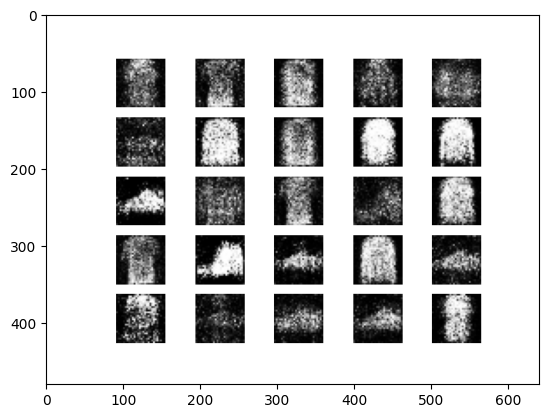

In [5]:
image = mpimg.imread(r"C:\Users\Ploita\Pictures\IA353_PC2_GAN\1000.png")
plt.imshow(image)
plt.show()

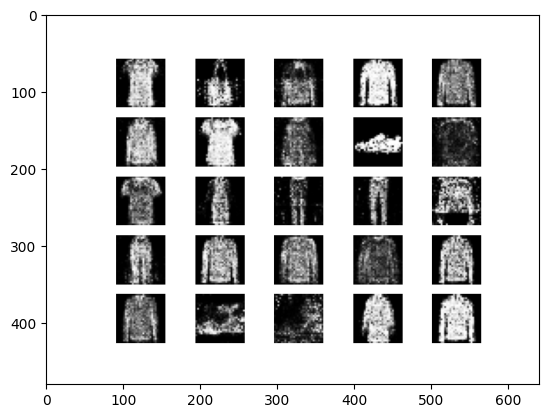

In [6]:
image = mpimg.imread(r"C:\Users\Ploita\Pictures\IA353_PC2_GAN\10000.png")
plt.imshow(image)
plt.show()

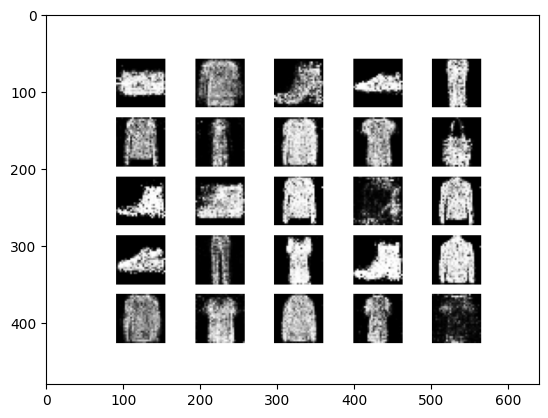

In [7]:
image = mpimg.imread(r"C:\Users\Ploita\Pictures\IA353_PC2_GAN\20000.png")
plt.imshow(image)
plt.show()

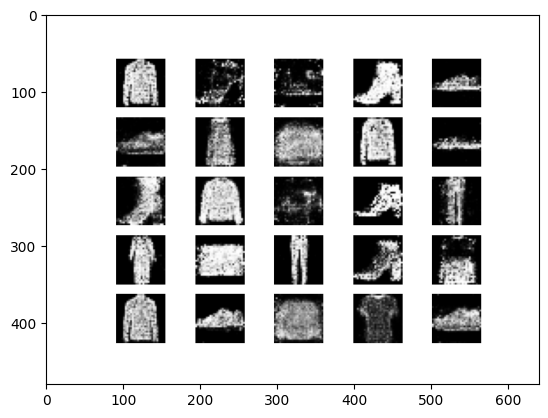

In [8]:
image = mpimg.imread(r"C:\Users\Ploita\Pictures\IA353_PC2_GAN\30000.png")
plt.imshow(image)
plt.show()